In [ ]:
# 1. Mount Google Drive & Setup
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch.cuda.amp as amp
import cv2

Mounted at /content/drive


In [ ]:
# 2. Create a results folder in MyDrive
results_folder = '/content/drive/MyDrive/FoodSegmentation_Results_Final'
os.makedirs(results_folder, exist_ok=True)

In [ ]:
# 3. Load category names
category_map = {}
with open('/content/drive/MyDrive/Task 1 Food Segmentation Dataset/FoodSeg103/category_id.txt', 'r') as f:
    for line in f.readlines():
        idx, name = line.strip().split(None, 1)
        category_map[int(idx)] = name.strip()

In [ ]:
# 4. Define directory paths
root_path = '/content/drive/MyDrive/Task 1 Food Segmentation Dataset/FoodSeg103'
image_folder = os.path.join(root_path, 'Images')
annotation_folder = os.path.join(root_path, 'ImageSets')
train_file = os.path.join(annotation_folder, 'train.txt')
test_file = os.path.join(annotation_folder, 'test.txt')
train_images = os.path.join(image_folder, 'img_dir/train')
train_annotations = os.path.join(image_folder, 'ann_dir/train')
test_images = os.path.join(image_folder, 'img_dir/test')
test_annotations = os.path.join(image_folder, 'ann_dir/test')


In [ ]:
# 5. Custom Dataset with txt integration
class FoodSegmentationDataset(Dataset):
    def __init__(self, img_folder, mask_folder, file_list, transform=None, target_size=(512, 512)):
        self.img_folder = img_folder
        self.mask_folder = mask_folder
        with open(file_list, 'r') as file:
            self.image_names = [line.strip() for line in file.readlines()]
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_name = self.image_names[index]
        image_path = os.path.join(self.img_folder, image_name)
        mask_path = os.path.join(self.mask_folder, image_name.replace('.jpg', '.png'))

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = mask.resize(self.target_size, Image.NEAREST)

        mask = np.array(mask, dtype=np.int64)
        return image, torch.tensor(mask)


In [ ]:
# 6. transformations for training images
train_transforms = T.Compose([
    T.Resize((512, 512)),
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=20, scale=(0.9, 1.1), shear=10),
    T.CenterCrop((512, 512)),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#  transformations for validation images
val_transforms = T.Compose([
    T.Resize((512, 512)),
    T.CenterCrop((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# 7. Data Loaders

complete_train_dataset = FoodSegmentationDataset(
    img_folder=train_images,
    mask_folder=train_annotations,
    file_list=train_file,
    transform=train_transforms
)


val_count = int(0.1 * len(complete_train_dataset))
train_count = len(complete_train_dataset) - val_count
train_dataset, val_dataset = random_split(complete_train_dataset, [train_count, val_count])


val_dataset.dataset.transform = val_transforms


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

test_dataset = FoodSegmentationDataset(
    img_folder=test_images,
    mask_folder=test_annotations,
    file_list=test_file,
    transform=val_transforms
)
test_loader = DataLoader(test_dataset, batch_size=4)


In [ ]:
# 8. Model Setup
segmentation_model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
segmentation_model.classifier[4] = nn.Conv2d(in_channels=256, out_channels=104, kernel_size=1)
segmentation_model.cuda()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:03<00:00, 44.6MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
# 9. Optimizer, Scheduler, Mixed Precision

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(segmentation_model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)
grad_scaler = amp.GradScaler()


<ipython-input-9-90d08e88a0c4>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = amp.GradScaler()


In [ ]:
# 10. Early Stopping Setup
class EarlyStopping:
    def __init__(self, patience=5, min_improvement=0):
        self.patience = patience
        self.min_improvement = min_improvement
        self.wait_counter = 0
        self.highest_score = None

    def should_stop(self, current_score):
        if self.highest_score is None or current_score > self.highest_score + self.min_improvement:
            self.highest_score = current_score
            self.wait_counter = 0
            return False
        else:
            self.wait_counter += 1
            return self.wait_counter >= self.patience

best_model_file = os.path.join(results_folder, 'best_model.pth')
early_stopping = EarlyStopping(patience=5, min_improvement=0.001)


In [ ]:
# 11. Training the model
num_epochs = 25
training_results = {'epoch': [], 'loss': [], 'val_mIoU': [], 'val_pixel_acc': [], 'val_dice': []}

for epoch in range(num_epochs):
    segmentation_model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader):

        if images.shape[0] == 0 or images.shape[2] < 32 or images.shape[3] < 32:
            print(f'Skipping invalid batch with shape: {images.shape}')
            continue

        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()

        try:
            with amp.autocast():
                predictions = segmentation_model(images)['out']
                loss = criterion(predictions, labels)

            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()

            total_loss += loss.item()

        except Exception as error:
            print(f"Skipping batch due to error: {error}")
            continue

    avg_loss = total_loss / len(train_loader)

    segmentation_model.eval()
    validation_miou, validation_dice, validation_pixel_acc = [], [], []
    with torch.no_grad():
        for images, labels in val_loader:
            if images.shape[0] == 0 or images.shape[2] < 32 or images.shape[3] < 32:
                print(f'Skipping invalid validation batch: {images.shape}')
                continue

            images, labels = images.cuda(), labels.cuda()

            try:
                predictions = torch.argmax(segmentation_model(images)['out'], dim=1).cpu().numpy()

                for predicted_mask, ground_truth_mask in zip(predictions, labels.cpu().numpy()):
                    intersection = np.logical_and(predicted_mask == ground_truth_mask, ground_truth_mask > 0).sum()
                    union = np.logical_or(predicted_mask > 0, ground_truth_mask > 0).sum()
                    iou = intersection / union if union > 0 else 0
                    validation_miou.append(iou)

                    dice = (2. * intersection) / (predicted_mask.size + ground_truth_mask.size)
                    validation_dice.append(dice)

                    pixel_accuracy = (predicted_mask == ground_truth_mask).mean()
                    validation_pixel_acc.append(pixel_accuracy)

            except Exception as error:
                print(f"Skipping validation batch due to error: {error}")
                continue

    lr_scheduler.step(np.mean(validation_miou))
    training_results['epoch'].append(epoch + 1)
    training_results['loss'].append(avg_loss)
    training_results['val_mIoU'].append(np.mean(validation_miou))
    training_results['val_pixel_acc'].append(np.mean(validation_pixel_acc))
    training_results['val_dice'].append(np.mean(validation_dice))

    if np.mean(validation_miou) >= early_stopping.highest_score if early_stopping.highest_score else 0:
        torch.save(segmentation_model.state_dict(), best_model_file)

    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {avg_loss:.4f}, val_mIoU: {np.mean(validation_miou):.4f}")

    if early_stopping.should_stop(np.mean(validation_miou)):
        print("Early stopping triggered!")
        break


  0%|          | 0/1122 [00:00<?, ?it/s]<ipython-input-11-793c764069f9>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():  # Using mixed precision for better efficiency
100%|██████████| 1122/1122 [44:19<00:00,  2.37s/it]

Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])


Epoch 1/25 - Loss: 2.0904, val_mIoU: 0.3053


100%|██████████| 1122/1122 [03:42<00:00,  5.04it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 2/25 - Loss: 1.4788, val_mIoU: 0.3604


100%|██████████| 1122/1122 [03:38<00:00,  5.13it/s]

Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])


Epoch 3/25 - Loss: 1.2837, val_mIoU: 0.4058


100%|██████████| 1122/1122 [03:39<00:00,  5.12it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 4/25 - Loss: 1.1485, val_mIoU: 0.4288


100%|██████████| 1122/1122 [03:38<00:00,  5.13it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 5/25 - Loss: 1.0275, val_mIoU: 0.4409


100%|██████████| 1122/1122 [03:38<00:00,  5.13it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 6/25 - Loss: 0.9341, val_mIoU: 0.4777


100%|██████████| 1122/1122 [03:38<00:00,  5.13it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 7/25 - Loss: 0.8336, val_mIoU: 0.4621


100%|██████████| 1122/1122 [03:39<00:00,  5.11it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 8/25 - Loss: 0.7622, val_mIoU: 0.4815


100%|██████████| 1122/1122 [03:39<00:00,  5.12it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 9/25 - Loss: 0.6826, val_mIoU: 0.4941


100%|██████████| 1122/1122 [03:41<00:00,  5.06it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 10/25 - Loss: 0.6232, val_mIoU: 0.4937


100%|██████████| 1122/1122 [03:39<00:00,  5.12it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 11/25 - Loss: 0.5528, val_mIoU: 0.4843


100%|██████████| 1122/1122 [03:40<00:00,  5.10it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 12/25 - Loss: 0.5133, val_mIoU: 0.4928


100%|██████████| 1122/1122 [03:40<00:00,  5.08it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 13/25 - Loss: 0.3800, val_mIoU: 0.5311


100%|██████████| 1122/1122 [03:39<00:00,  5.10it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 14/25 - Loss: 0.3211, val_mIoU: 0.5289


100%|██████████| 1122/1122 [03:38<00:00,  5.13it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 15/25 - Loss: 0.2857, val_mIoU: 0.5267


100%|██████████| 1122/1122 [03:39<00:00,  5.12it/s]

Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])


Epoch 16/25 - Loss: 0.2582, val_mIoU: 0.5427


100%|██████████| 1122/1122 [03:40<00:00,  5.10it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 17/25 - Loss: 0.2375, val_mIoU: 0.5290


100%|██████████| 1122/1122 [03:39<00:00,  5.11it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 18/25 - Loss: 0.2159, val_mIoU: 0.5219


100%|██████████| 1122/1122 [03:40<00:00,  5.08it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 19/25 - Loss: 0.1979, val_mIoU: 0.5423


100%|██████████| 1122/1122 [03:39<00:00,  5.12it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 20/25 - Loss: 0.1616, val_mIoU: 0.5365


100%|██████████| 1122/1122 [03:38<00:00,  5.13it/s]


Skipping batch due to error: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])
Epoch 21/25 - Loss: 0.1452, val_mIoU: 0.5421
Early stopping triggered!


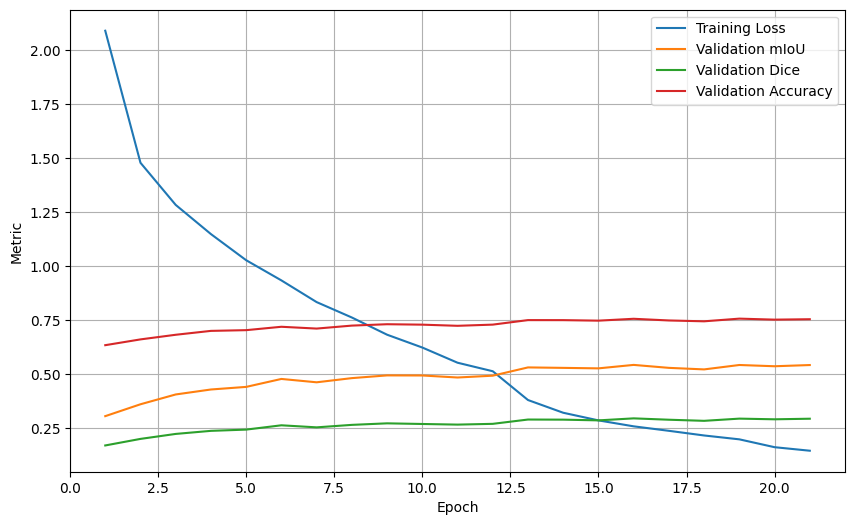

In [ ]:
# 12. Save metrics & plot
results_file_path = os.path.join(results_folder, 'training_results.csv')
pd.DataFrame(training_results).to_csv(results_file_path, index=False)


plt.figure(figsize=(10, 6))
plt.plot(training_results['epoch'], training_results['loss'], label='Training Loss')
plt.plot(training_results['epoch'], training_results['val_mIoU'], label='Validation mIoU')
plt.plot(training_results['epoch'], training_results['val_dice'], label='Validation Dice')
plt.plot(training_results['epoch'], training_results['val_pixel_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.show()


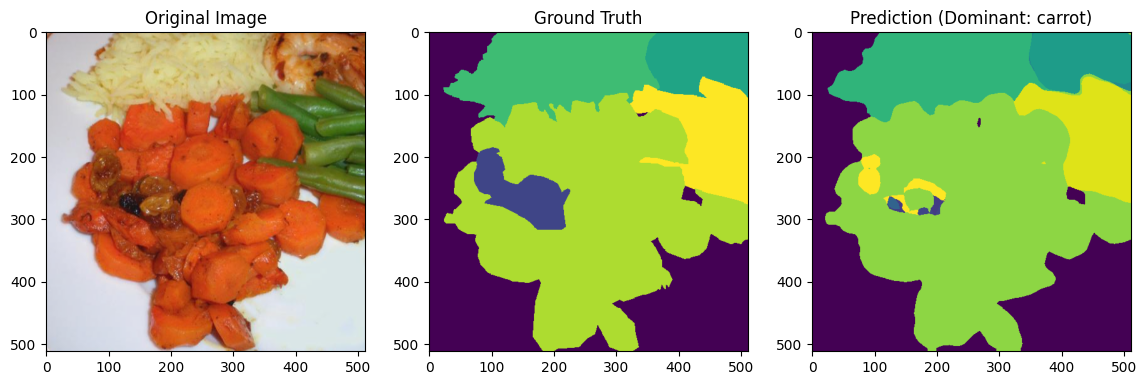

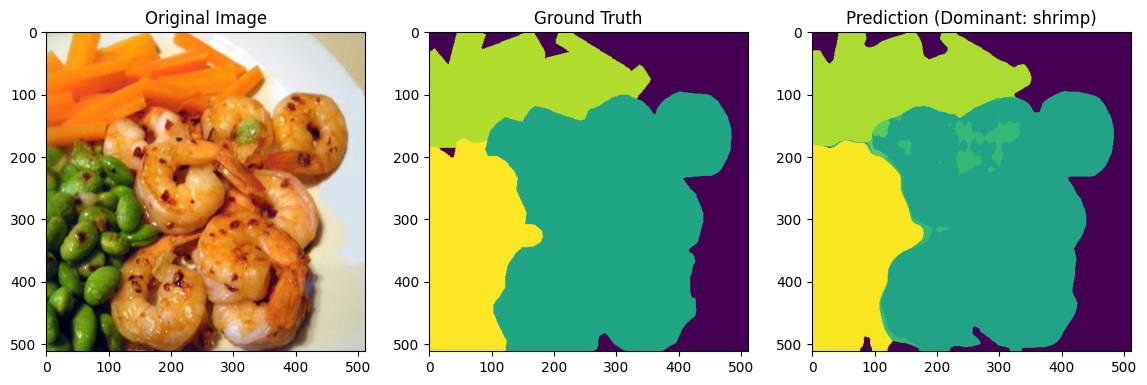

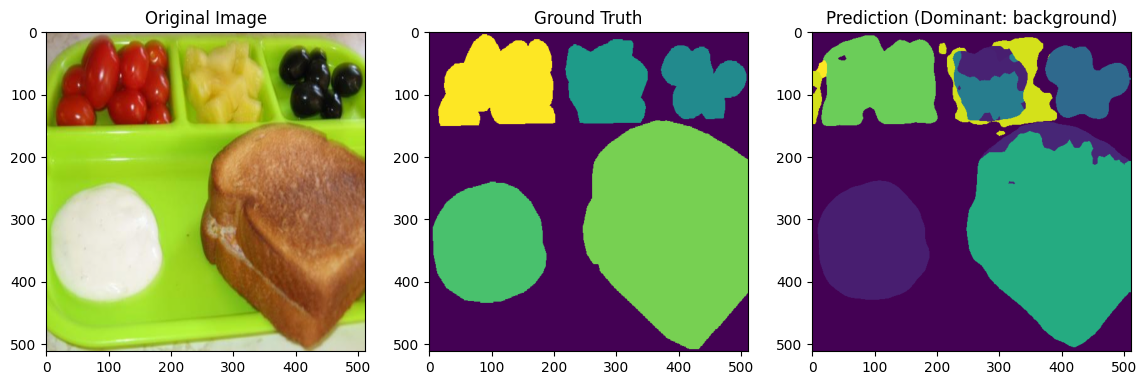

In [ ]:
# 13. Visualize predictions and save results
segmentation_model.load_state_dict(torch.load(best_model_file))
segmentation_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        predictions = torch.argmax(segmentation_model(images)['out'], dim=1).cpu()
        for idx in range(3):
            plt.figure(figsize=(14, 5))

            plt.subplot(1, 3, 1)
            plt.title('Original Image')
            img_np = images[idx].permute(1, 2, 0).cpu().numpy()
            img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
            img_np = np.clip(img_np, 0, 1)
            plt.imshow(img_np)


            plt.subplot(1, 3, 2)
            plt.title('Ground Truth')
            plt.imshow(labels[idx].cpu())


            dominant_class = torch.mode(predictions[idx].flatten())[0].item()
            plt.subplot(1, 3, 3)
            plt.title(f'Prediction (Dominant: {category_map.get(dominant_class, "Unknown")})')
            plt.imshow(predictions[idx])
            plt.show()

        break
